# Batch analysis of cosmic rays using Drift Tubes detectors
Edited by `Group 10`:
- Alessandro Marcomini (2024286)
- Andrea Scanu (2022460)
- Luca Castelli (1243439)
- Pietro Miglioranza (2029265)

This project aims to reconstruct a series of muons trajectories which pass through four different detectors. Every detector is composed by 4 layers and every layer is composed by 16 cells, this means 64 cells per detector. Each cell measures the time arrival of the electronic signal released at the passage of a charged particle: the particle ionizes the cell content and the produced electrons drift at constant velocity towards the anodic wire at the center of the cell.
The other goal of this project is to exploit the capability of the Daks distributed framework to enhance the performances of a Python-based analysis code: in particular, we run the code on a Dask cluster built over four virtual machines provided by CloudVeneto. Also, using the Dask framework we minimize the computation in our machines and we distribuite the tasks that can be parallelized over the VMs in order to decrease computation times. 

## 0.1 Cluster Settings

We choose Dask to improve our project because it is designed to work with big and distributed datasets using a Python-based language. The native similarity to Pandas library and the compatibility with Python make Dask a convenient choice on the basis of our knowledge and the one of potential readers.  

The first part of the configuration that we make is the clustering of the four VMs that we used: we connect 16 workers along the virtual machines on CloudVeneto servers. We set up one of the machines as the scheduler and also as a worker, the other ones as workers only. The bash commands to do so are: `dask-scheduler` to start the scheduler and `dask-worker IP:PORT --nprocs 4` to start a worker with 4 processors and automatic (balanced) assignment of memory and threads.
In particular we choose the following configuration:

- scheduler on first VM;
- 4 workes with 1 thread and 2 GiB of memory for each worker on all VMs;

In the end we create a cluster with 16 workers, 16 cores and 32.80 GiB of memory. This is the configuration that we select as the best to run our project on, but we previously tried different configurations in order to optimize the times of computation and to exploit all of the possibilities offered by our machines. We have verified what the Dask documentation suggests to do while working with Python code: Python is not optimized for working on multiple threads, so the best way is to have as many workers as possible with just one thread each. 
A test was run with 81 files ($\sim 81$ MB) on the four VMs and we have seen that the total time needed to run the algorithm is about:
- 430s with 16 workers, 1 thread each;
- 830s with 8 workers, 2 threads each;
- 2090s with 4 workers, 4 threads each.

Once the machinery is configured, it is sufficient to start the Client (which is in our case the same VM that hosts the scheduler).

In [1]:
#importing the useful libraries
import dask
from dask.bytes import read_bytes
from dask.distributed import Client
from dask_ml.linear_model import LinearRegression
import dask.dataframe as dd
import pandas as pd
import numpy as np
import time
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from numpy.polynomial import polynomial as P
start_time = time.time()

In [2]:
#connecting the client to the scheduler
client = Client('10.67.22.186:8786')
client

Client Scheduler: tcp://10.67.22.186:8786 Dashboard: http://10.67.22.186:8787/status,Cluster Workers: 16 Cores: 16 Memory: 32.80 GB


## 1.1 Collecting data
In the following we gather the data which are stored in an s3 bucket by the means of the Dask function `read_bytes`. This returns a list of delayed objects that will turn into one bit string each, encoding the datasets.  

In [3]:
#Gather data from the cloud
pub = #CENSORED
priv = #CENSORED
_ , raw_data = read_bytes('s3://MAPD_miniDT_batch/*.dat',sample=False, delimiter = b"\n",
                 **{
                     'use_ssl':False,
                     'key':pub,
                     'secret':priv,
                     'client_kwargs':{
                         'endpoint_url':'https://cloud-areapd.pd.infn.it:5210',
                         'verify':False
                     }
                 })

L = len(raw_data)

## 1.2 Decoding data
As mentioned before the collected hits are encoded as 64bit words and each of them represents a row in a DataFrame with data respecting the following structure:

- 0-4 $\color{#58D68D}{\text{(5 bits)}}$ → $\color{#58D68D}{\textbf{TDC}}$
- 5-16 $\color{#F39C12}{\text{(12 bits)}}$ → $\color{#F39C12}{\textbf{BX}}$
- 17-48 $\color{#A569BD}{\text{(32 bits)}}$ → $\color{#A569BD}{\textbf{ORBIT}}$
- 49-57 $\color{#2E86C1}{\text{(9 bits)}}$ → $\color{#2E86C1}{\textbf{CHAN}}$
- 58-60 $\color{#E74C3C}{\text{(3 bits)}}$ → $\color{#E74C3C}{\textbf{FPGA}}$
- 61-63 $\color{#1C2833}{\text{(3 bits)}}$ → $\color{#1C2833}{\textbf{HEAD}}$

As the bit position inside the string can be easily mistaken because of the lack of information regarding the endianess of encoding, we have performed a trial-and-error approach and investigated multiple configurations and responses to the native Python deconding functions to retreive the best decoding: this has been chosen as the one whose results seemed the most reasonable to us, given the fact that we expect a large amount of rows with values such as `HEAD=2` and `FPGA<4`. In the end, for an example 64bit word, we divide the six categories as follows:

\begin{equation}
  \color{#1C2833}{010} \color{#E74C3C  }{000} \color{#2E86C1}{111100100} \color{#A569BD}{00011100001011010011110010111001} \color{#F39C12}{000001011101} \color{#58D68D}{10101}
\end{equation}

The function below is able to decode the strings with the previous scheme and return a Pandas dataframe. We apply it to the dataset via the delayed Dask method: this ensures that at this point no real computation on the data is made, but everything is set to execute once we trigger opertions by the `.compute()` method. Finally, since it exists a huge compatibility between Dask DataFrames and Pandas ones, we can move to a Dask Dataframe to perform all the distributed computations over the workers.

In [4]:
#Function to turn a sequence of bits to a dataframe with the right encoding
def data_decoding(fp):
    words = np.fromstring(fp, dtype = '<u8')
    data = np.zeros((words.shape[0], 6), dtype = "u4") 
    data[:,0] =  words & 0b11111 # TDC
    data[:,1] = (words & 0b11111111111100000) >> 5 # BX
    data[:,2] = (words & 0b1111111111111111111111111111111100000000000000000) >> 17 # ORBIT
    data[:,3] = (words & 0b1111111110000000000000000000000000000000000000000000000000) >> 49 # CHAN
    data[:,4] = (words & 0b1110000000000000000000000000000000000000000000000000000000000) >> 58 # FPGA
    data[:,5] =  words >> 61 #HEAD
    return pd.DataFrame(data=data, columns=['TDC','BX','ORBIT','CHAN','FPGA','HEAD'])

In [5]:
z = [dask.delayed(data_decoding)(raw_data[i][0]) for i in range(L)]

data_types = {'TDC':'uint8', 'BX':'uint16', 'ORBIT':'uint32', 'CHAN':'uint16', 'FPGA':'uint8', 'HEAD':'uint8'}
df = dd.from_delayed(z, meta=data_types)

## 1.3 Preparing the DataFrame: removal of accessory data and absolute time calculation

The following cells remove all data not pertaining to the TDC hits. Following the project documentation, we are removing all the rows which do not have compatible values of HEAD, FPGA, TDC and CHAN. In particular, to work on data concerning the experiment under investigation we impose:

* HEAD = 2
* FPGA < 2
* CHAN < 129

From the theory, we also know that the features `ORBIT`, `BX` and `TDC` allow us to reconstruct the absolute time in nanoseconds of muon detections (from a given zero-point) by the means of the following formula:

$$
t_{abs} = 25 \cdot \left(3564\cdot\text{ORBIT} + \text{BX} + \frac{\text{TDC}}{30}\right)
$$

Hence, we compute the absolute time and remove from the dataset the columns storing useless information for the trajectorties determination. 

Finally, we also create of a new column which contains a boolean value marking the scintillator signals (which allow us to affirm that a muon has hit the detector).

In [6]:
# drop head!=2 and unused channels
df = df[(df['HEAD']==2) & (df['FPGA']<2) & (df['CHAN']<129)]
#Computation of the absolute time: add a correspondig column
df['ABS_TIME'] = 25.*(df['ORBIT']*3564. + df['BX'] + df['TDC']/30.)
#From the informations about the channel and the fpga we reconstruct the number of the chamber
df['CHAMBER'] = (df['CHAN'] // 64) + 2*df['FPGA']
#We add a columun marking the scintillators signals
df['VALID'] = (df['FPGA']==1)&(df['CHAN']==128)

In [7]:
#We drop the column we are not interested anymore
df = df.drop('TDC', axis=1)
df = df.drop('BX', axis=1)
df = df.drop('FPGA', axis=1)
df = df.drop('HEAD', axis=1)

In [8]:
df.head()

,ORBIT,CHAN,ABS_TIME,CHAMBER,VALID
4,3387200947,75,3.017996e+14,1,False
5,3387200955,105,3.017996e+14,1,False
6,3387200955,107,3.017996e+14,1,False
7,3387200973,126,3.017996e+14,1,False
8,3387200955,55,3.017996e+14,2,False


# 2 Data analysis

## 2.1 Filtering suitable orbits

At this point of the code, if we look at the Dataframes we notice that there are some chunks of data that are difficult to analyse: e.g., there are orbits with too many hits that belong to different muons trajectories or noisy hits. The idea is to drop all of the portion of dataset that could increase computing time or produce misleading results. The choices that we have made are:

* Orbits with less than 3 hits or more than 17 (boundaries to be able to perform a linear fit and be sure to have no more than one event per orbit)
* Orbits with more than one scintillator signal
* Drop the rows with the signal of the scintillator

This operations allow us to get rid of extra data

## 2.1 Determining Left/Right positions (unsolved ambiguity)

With the filtered Dataframe it is possible to estimate the coordinates of every hit. The information about the muons trajectories is stored inside the columns with the drift times (since it is related to the spatial coordinates of the hits) that we compute below. It is worth recollecting that the `ORBIT` counter is set so that no more than one muon per orbit is expected. As reported above, we want to keep all and only rows corresponding to and orbit where a single muon count has been register and hence the scintillator can provide unambiguous information regarding its arrival time. 
\
The code below updates the Dataframe following this instructions:

* Group the events by `ORBIT` and check if there is one and only scintillator click inside that orbit 
* Collect the time pedestal $t_0$ as the absolut time of arrival inside the scintillator channel
* Create an additional column in the Dataframe with the relative time (`DIFF_TIME`) as $t_{abs} - t_0$

Afterwards, we proceed by translating the time information into a spatial one as follows:

* Drop the rows with the signal of the scintillator
* By the means of the expression below, evaluate the left/right coordinates for every hit
* Create an additional column for each of them and get rid of no more useful data

The formula used to evaluate the spatial coordinates is:

\begin{equation}
x_{L,R} = \pm v_{drift} \ ( t_{absolute} - t_0 + t_{shift} ) + x_{shift}
\end{equation}

The $\pm$ sign is set to get the left/right expected coordinate, respectively. The expression above takes into account two different corrections: a time shift and a spatial shift.
The former is due to the scintillator error on the measure of the first hit, which has an intrinsic delay due to electronics. The latter is the correction due to the position of the cell that measured the hit (corresponding to its horizontal position in a frame of reference where the leftmost point of each layer is aligned with the vertical axis).

To perform the linear fit in the chambers it is necessary to have also the $z$ coordinate, i.e. the height of the layer where a hit has been measured. 
The vertical configuration of the apparatus is described in the assignment document and, assuming that each cell is hit at the center of its vertical extension, it is thus sufficient to create a column in which we store all of the $z$ values.
\
At the end of this section the dataframe is ready for further analysis.

In [9]:
#Define functions for relative time computations and to move to spatial coordinates 

def space_shift(chamber):
    shift_list = np.array([219.8,977.3,1035.6,1819.8])
    return shift_list[chamber]

def time_shift(chamber):
    shift_list = np.array([95.0-1.1,95.0+6.4,95.0+0.5,95.0-2.6])
    return shift_list[chamber]

def x_trasl(n_cell):
    #Shift of 8*42 to the left to avoid signed
    x_cell = (n_cell//4)*42 + ((n_cell%4)//2)*21+21 
    return x_cell

def z_trasl(n_cell):
    z_cell = 19.5 - 26*(n_cell%2) - 13*((n_cell%4)//2)
    return(z_cell)

In [10]:
#Keep only suitable orbits
def orbit_filters(df):
    # Checking the scintillator activation
    if df.VALID.any():
        val = df.VALID.sum()
        # Discards orbits with multiple scintillator activations
        if val<2:
            L = df.size//5 # dd.DataFrame.size returns the product column x rows of the dataframe
            accepted_hits = (L > 2) and (L < 18)
            # Filtering w.r.t. the number of hits
            if accepted_hits:
                t0 = float(df[df['VALID']==True]['ABS_TIME'])
                df = df.assign(DIFF_TIME = df['ABS_TIME']-t0)
                return df

In [11]:
data_types = {'ORBIT':'uint32', 'CHAN':'uint16', 'ABS_TIME':'float64', 'CHAMBER':'uint8', 'VALID':'bool', 'DIFF_TIME':'float64'}
df1 = df.groupby('ORBIT').apply(orbit_filters,meta = data_types).dropna()
df1 = df1.reset_index(drop=True).persist()

In [12]:
df1.head()

,ORBIT,CHAN,ABS_TIME,CHAMBER,VALID,DIFF_TIME
0,2399681,48,2.138116e+11,2,False,-41.666656
1,2399681,122,2.138116e+11,3,False,55.833344
2,2399681,47,2.138116e+11,2,False,157.500000
3,2399681,128,2.138116e+11,4,True,0.000000
4,2399681,49,2.138116e+11,2,False,20.000000


In [13]:
#dropping the rows which contain scintillator hits
df1 = df1[df1['CHAN']!=128]

In [14]:
#applying the time correction w.r.t. the chamber
df1['DIFF_TIME'] = df1['DIFF_TIME']+df1['CHAMBER'].map_partitions(time_shift).persist()

In [15]:
#removing non physical results (we must have a time difference between absolute time and t_0 less then 400 ns, due to cells dimension) 
df1 = df1[(df1['DIFF_TIME']>0) & (df1['DIFF_TIME']<400)]

In [16]:
df1.head()

,ORBIT,CHAN,ABS_TIME,CHAMBER,VALID,DIFF_TIME
0,2399681,48,2.138116e+11,2,False,53.833344
1,2399681,122,2.138116e+11,3,False,148.233344
2,2399681,47,2.138116e+11,2,False,253.000000
4,2399681,49,2.138116e+11,2,False,115.500000
5,2399681,120,2.138116e+11,3,False,284.900031


In [17]:
#dropping the valid column
df1 = df1.drop('VALID', axis=1)
#passing from CHAN number to CELL number
df1['CELL']=df1['CHAN']%64
#getting rid of the CHANNEL column
df1 = df1.drop('CHAN', axis=1)

In [18]:
#making the columns with the two possibile x coordinates for each cell 
x_r = 0.0538*(df1['DIFF_TIME']) + x_trasl(df1['CELL'])
x_l = -0.0538*(df1['DIFF_TIME']) + x_trasl(df1['CELL'])
df1['X_L'] = x_l
df1['X_R'] = x_r
#making the column with the z coordinate for each cell
z = df1['CHAMBER'].map_partitions(space_shift) + z_trasl(df1['CELL'])
df1['Z'] = z

In [19]:
df1.head()

,ORBIT,ABS_TIME,CHAMBER,DIFF_TIME,CELL,X_L,X_R,Z
0,2399681,2.138116e+11,2,53.833344,48,522.103766,527.896234,1055.1
1,2399681,2.138116e+11,3,148.233344,58,622.025046,637.974954,1826.3
2,2399681,2.138116e+11,2,253.000000,47,490.388600,517.611400,1016.1
4,2399681,2.138116e+11,2,115.500000,49,518.786100,531.213900,1029.1
5,2399681,2.138116e+11,3,284.900031,56,593.672378,624.327622,1839.3


# 3 Linear fit and resolution

The linear fit is the method we use to find the trajectory of muons. We assume that muons travel through the detectors without curving their trajectory during this path and move on a straight line. At this point of the code we did not solve the L/R ambiguity yet, so we cannot just operate a single linear fit. Hence, The choice that we make is to investigate all the possible path combinations (LLLL, LLLR, LLRL,..., RRRR) and take as the most probable combination of left/right positions the one with the best score provided by a $\chi^2$ test.

## 3.1 Resolving L/R ambiguity

Since the detectors aren't able to recognise if a hit has been measured on the left or on the right of the cell (they only register the distance from the center of the cell), we define the following function that operates the fit and returns the optimal (lowest $\chi^2$) L/R pattern. We apply this function on a Dataframe grouped by orbit and chamber: as a result, three possible scenarios arise:
- In a given orbit, the chamber registers two or less hits: in this case the data are unsufficient to solve the L/R ambiguity (two simmetric, perfect regressions arise and there is no way to choose among them), and the fit is not performed;
- In a given orbit, the chamber registers three or four hits: this is the optimal case, since it means that 3/4 or 4/4 of the four layers in the chamber have registered and event. The fit is hence regularly performed;
- In a given orbit, the chamber registers more than four hits: this means that there are some extra counts due to potential noise or multiple events. Since this will unavoidably affect our performances and there is no way for us to distinguish between signal and non-signal clicks, we do not perform the fit.

At the end of this code section, the Dataframe is reduced so that each rows contains some index variables and the correct $x$ and $z$ positions, in our absolute frame of reference.

In [20]:
#function for the local fit that will be performed on each chamber
def ambiguity_solve(DF):
    fit_params = []
    #reading inputs
    x_l = np.array(DF.X_L)
    x_r = np.array(DF.X_R)
    z = np.array(DF.Z)
    scoremax = 100
    best_x = []
    #case of four hits on a chamber
    if len(x_l)==4 :
        x_0 = (x_l[0], x_r[0])
        x_1 = (x_l[1], x_r[1])
        x_2 = (x_l[2], x_r[2])
        x_3 = (x_l[3], x_r[3])
        #computing all the possible left-right combinations
        X = np.array(list(product(x_0, x_1, x_2, x_3)))
        #fitting with a line and finding which combination gives the minimum chi-square
        fitted = np.apply_along_axis(lambda x : fit(x,z), 1, X) #Returns coeffs ([:,0]) and scores ([:,1])
        best_x = X[np.argmin(fitted[:,1])]
        DF = DF.assign(best_X = np.array(best_x))
        return DF
    #case of three hits on a chamber, same as above
    if len(x_l)==3 :
        x_0 = (x_l[0], x_r[0])
        x_1 = (x_l[1], x_r[1])
        x_2 = (x_l[2], x_r[2])
        X = np.array(list(product(x_0, x_1, x_2)))
        fitted = np.apply_along_axis(lambda x : fit(x,z), 1, X) #Returns coeffs ([:,0]) and scores ([:,1])
        best_x = X[np.argmin(fitted[:,1])]
        DF = DF.assign(best_X = np.array(best_x))
        return DF
    else: pass

#function to compute the chi square    
def chi_squared(x,y,coef):
    calc = coef[0]+coef[1]*x
    chi2 = ((y-calc)**2)/y
    return sum(chi2)/(len(y)-2)

def fit(x,z):
    coef = P.polyfit(x,z,1)
    score = chi_squared(x,z,coef)
    return coef, score

In [21]:
#setting the format for the output dataframe
data_types = {'ORBIT':'uint32','ABS_TIME':'float64', 'CHAMBER':'uint8','DIFF_TIME':'float64','CELL':'uint16',
               'X_L':'float64', 'X_R':'float64', 'Z':'float64', 'best_X':'float64'}

#performing the local fit on each chamber, for each orbit
dfk = df1.groupby(['ORBIT','CHAMBER']).apply(ambiguity_solve, meta=data_types).reset_index(drop=True).persist()

In [22]:
#dropping columns we do not need anymore
dfk = dfk.drop('X_L', axis=1)
dfk = dfk.drop('X_R', axis=1)
dfk = dfk.drop('ABS_TIME', axis=1)

In [23]:
dfk.head()

,ORBIT,CHAMBER,DIFF_TIME,CELL,Z,best_X
0,1135298,2,20.500000,47,1016.1,502.897100
1,1135298,2,154.666656,46,1042.1,512.321066
2,1135298,2,167.999985,48,1055.1,515.961601
3,1135298,2,321.333328,49,1029.1,507.712267
4,1206251,3,89.066672,60,1839.3,646.208213


## 3.2 Estimation of the angular resolution

Using two different kind of fits for every orbit and comparing the two angular coefficient it is possible to estimate the angular resolution. In particular, we focus on the local fit performed on the chamber number 2 (middle one) and a global fit within the entire apparatus (chambers 1,2 and 4). There colud be potential issues in the case in which there are not enough hits in the second chamber: in this cases we just discard the orbit and we don't use it to perform the estimation (eventually, this is the case of not enough "vertical" muons that fail to cross properly the entire apparatus).

### 3.2.1 Local Fit

To go through the local fit operation we have to extract from the dataset only the hits in the second chamber and then fit them.

In [24]:
#function to find the trajectories after resolving the left-right ambiguity
def fit_func(df):
    x = np.array(df.best_X)
    y = np.array(df.Z)
    coef = P.polyfit(x,y,1)
    return coef    

In [25]:
def LocalFit(df):
    x = np.array(df.best_X)
    y = np.array(df.Z)
    coef = P.polyfit(x,y,1)
    d = {'a_local':[float(coef[1])],'b_local':[float(coef[0])]}
    return pd.DataFrame(data = d)

In [26]:
#we compute the so-called "Local track" using only the hits from Chamber 2
df_ch2 = dfk[dfk["CHAMBER"]==2]
fit = df_ch2.groupby('ORBIT').apply(LocalFit,meta={'a_local':'float','b_local':'float'})                                                                                         

In [27]:
fit.head()

,,a_local,b_local
ORBIT,,,
2399681,0,8.155917,-3204.406635
2698072,0,-3.529065,2651.487662
5046279,0,-0.899929,1479.573974
5226862,0,10.281819,-4273.065088
5722385,0,0.907694,606.856907


### 3.2.2 Global fit
Using the same approach as before, we perform a linear regression on all the hits in a given orbit, belonging to chambers 0,2,3 (the aligned ones).

In [28]:
#to performe the global fit we exclude Chamber 1
dfk2 = dfk[dfk['CHAMBER']!=1]
#fitting and storing the results for both local and global fit in the same dataframe
fit_global = dfk2.groupby('ORBIT').apply(LocalFit,meta={'a_local':'float','b_local':'float'})
fit["a_global"] = fit_global['a_local']
fit['b_global'] = fit_global['b_local']
fit = fit.persist()

In [29]:
fit.head()

,,a_local,b_local,a_global,b_global
ORBIT,,,,,
2399681,0,8.155917,-3204.406635,7.723254,-2979.468932
2698072,0,-3.529065,2651.487662,-3.186001,2494.436034
5046279,0,-0.899929,1479.573974,-12.268533,7132.477256
5226862,0,10.281819,-4273.065088,8.430385,-3317.186179
5722385,0,0.907694,606.856907,0.728224,283.654810


### 3.2.3 Angular resolution 
An estimate of the angular resolution of the detector can be found as the difference between the angle found by the local and the global fit, which can be obtained from the slope of the linear regressions (taking care of periodicity and relative sign).

Finally, we plot the the distribution of the angular difference between the plot to visualize the detectors resolution.

In [30]:
fit['angles_diff'] = (np.heaviside(np.arctan(fit.a_local)-np.arctan(fit.a_global),0)*(np.arctan(fit.a_local)-np.arctan(fit.a_global)))%(np.pi/2)-(np.heaviside(-np.arctan(fit.a_local)+np.arctan(fit.a_global),0)*(-np.arctan(fit.a_local)+np.arctan(fit.a_global))%(np.pi/2))

In [31]:
fit.head()

,,a_local,b_local,a_global,b_global,angles_diff
ORBIT,,,,,,
2399681,0,8.155917,-3204.406635,7.723254,-2979.468932,0.006761
2698072,0,-3.529065,2651.487662,-3.186001,2494.436034,-0.028013
5046279,0,-0.899929,1479.573974,-12.268533,7132.477256,0.756691
5226862,0,10.281819,-4273.065088,8.430385,-3317.186179,0.021113
5722385,0,0.907694,606.856907,0.728224,283.654810,0.107631


In [32]:
# Take the comlumn corresponding to the anguar difference between local and global fit
computed_angles = fit.angles_diff.compute()
# Get rid of the coincident ones 
computed_angles = computed_angles[computed_angles!=0]
# Conversion from randiants to milliradiants
computed_angles= computed_angles*1000

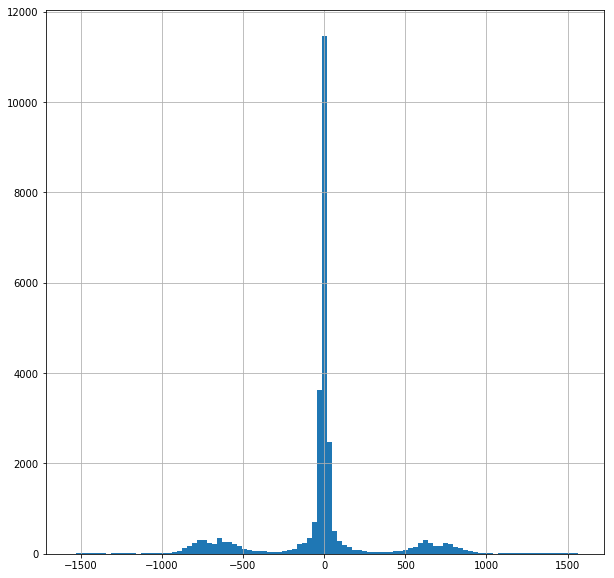

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
computed_angles.hist(density=False,ax=ax,bins=101)
plt.show()

The above plot depicts a main peak and some background noise. The overall spead of the central peak is about 60 mrad (stddev) while the mean value is close to 0 within one milliradiant. 

# 4 Visualization 

Here we present the code which allows us to visualize events on the whole apparatus and plot some example events.

In [34]:
#function to visualize an event
def global_plot(DF_point, DF_fit, orbit):
    x_sample = DF_point[DF_point['ORBIT']==orbit].best_X.compute()
    y_sample = DF_point[DF_point['ORBIT']==orbit].Z.compute()
    fig,ax = plt.subplots(figsize=(16,10))
    ax.set_xlim((0,703))
    ax.set_ylim((190,2000))
    x_start = 26
    y_start = 4
    frame_shift=[219.8,1035.6,1819.8]
    xr = np.linspace(0,800,800)
    yr = float(DF_fit.loc[orbit].a_global.compute())*xr + float(DF_fit.loc[orbit].b_global.compute())
    yr_loc = float(DF_fit.loc[orbit].a_local.compute())*xr + float(DF_fit.loc[orbit].b_local.compute())
    for k in frame_shift:
        for i in range(4):
            for j in range (16):
                x = x_start+42*j-(21*(i%2))
                y = k + y_start+13*i-26
                ax.add_patch(Rectangle((x, y), 42, 13,
                         edgecolor = 'grey',
                         facecolor = 'blue',
                         fill=False,
                         lw=1))
                plt.plot(xr,yr,color='tab:blue',lw=0.8) #global track
                plt.plot(xr,yr_loc,color='tab:red',lw=0.8) #local track
                plt.scatter(x_sample,y_sample,color='tab:orange') #hits
          



    plt.axis('off')
    plt.show()

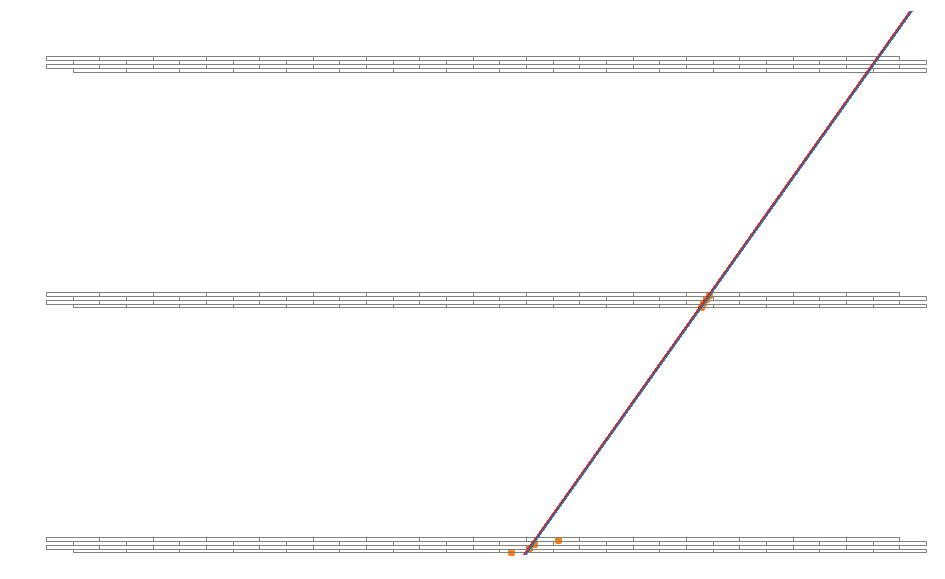

In [35]:
global_plot(dfk2, fit, 384402297)

Here is an event for which the global and local fit are perfectly aligned, even though the L/R ambiguity in the last chamber looks solved suboptimally.

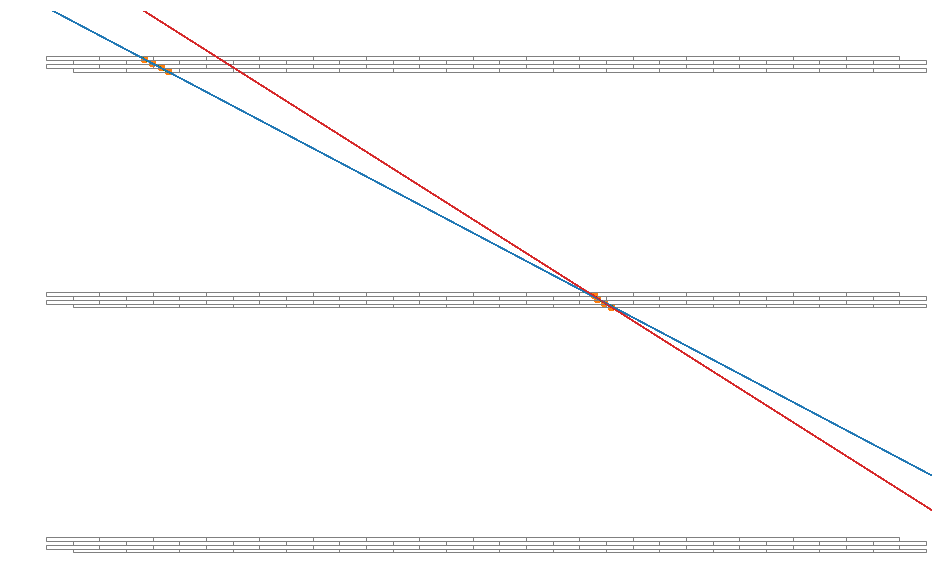

In [36]:
global_plot(dfk2, fit, 44505976)

Above, the case for two close tracks. Here we notice how the diagonal trajectory of the muon fails to intercept all three chambers.

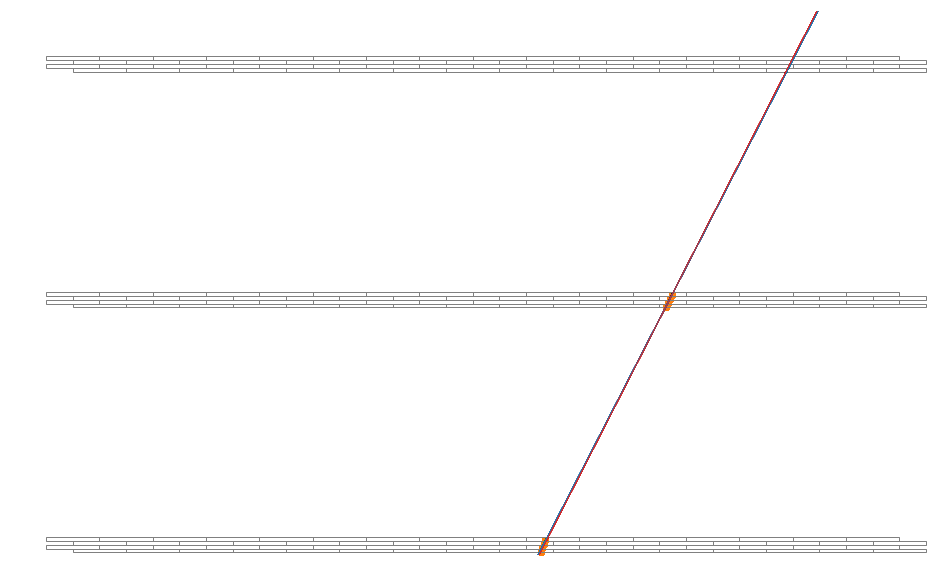

In [37]:
global_plot(dfk2,fit,97806014)

Finally, the plot above shows a perfectly reconstracted trajectory with absolute compatibility between local and global fits.

In [38]:
print("---%s seconds ---"%(time.time()-start_time))

---571.5563061237335 seconds ---


# 5 Track reconstruction issues 
In the case below, a clear difference appears between the two fits: the reason is likely to be a non-optimal analysis rather than a limited detector efficiency. In particular, we believe the algorithm fails to recognize the correct L/R pattern in the central cell (maybe due to the limited power of a simple $\chi^2$ test).

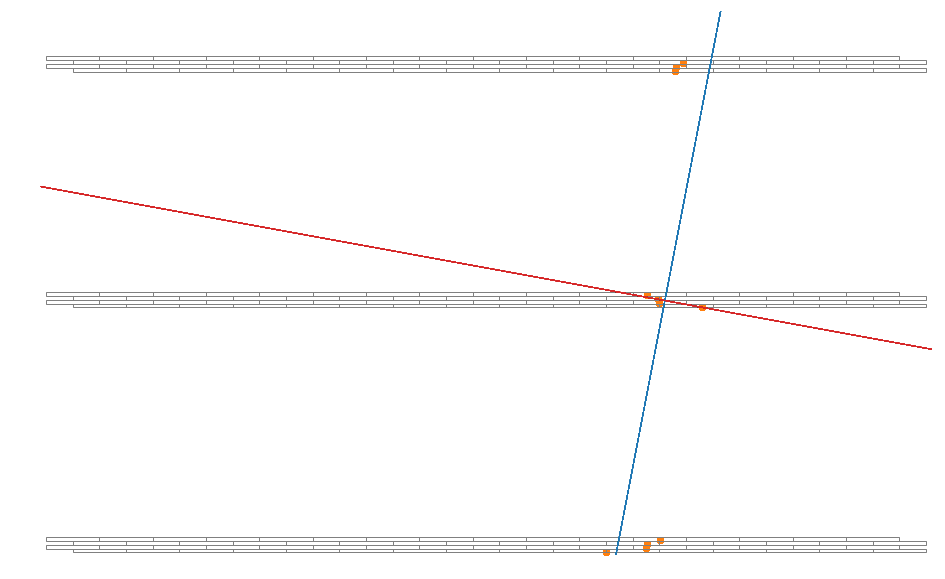

In [39]:
global_plot(dfk2, fit, 138714055)

# 6 Computational time optimization

A fundamental tool in our algorithm is the "persist()" function, given by dask. It allows us to keep our data in memory and by doing so we speed up our algorithm. To save some time the study about the persist has been permormed with just 18 files. By using appropriately the function we passed from 23 minutes needed to run the whole algorithm to just 135 seconds. 
Once we found the right configuration we proceed to analyze the whole dataset.

# 7 Issues faced

The algorithm presented in this notebook has been produced after several trials. The number of file quoted in the previous paragraph is not random. In a previous version of our code we implemented different instructions to filter our dataset and, in that configuration, we could only process 18 files. We talk about this because in that configuration (shown in the bottom of this notebook) the computational time of the whole algorithm was about 90 seconds. 

However, we have seen that a function essential to our code, namely "value_counts()" saturated the memory we had, even when we doubled our resources. It was quite strange, because the entire dataset can be held by just one processor. By calling the quoted function, several process occured, as we could seen from the dask dashboard. We were not able to solve this problem, so we need to change our code to the one presented above. 

In the present configuration the algorithm works, but we cannot state that the problem is entirly solved. Even if we can process the whole dataset, by looking at the dashboard we can still see that the memory of our workes is filled up to 17 Gb, while the total weight of the dataset is few Mb. 

Thus, we think that a better way to solve the problem can be achived, but it is beyond our capabilities. 